In [28]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

### Helper functions that are used in the rest of the notebook

In [29]:
def extract_nodes(df):
    """
    Extracts the nodes from a dataframe
    :param df: dataframe with source and target columns
    :return: set of nodes
    """
    return set(df['source'].unique()).union(set(df['target'].unique()))

def load_nodes(file_path):
    """
    Loads the nodes from a file
    :param file_path: path to the file
    :return: set of nodes
    """
    # much faster to do the operations on dataframes
    df = pd.read_csv(file_path, delimiter = ' ', names=['source', 'target', 'day'])
    nodes = extract_nodes(df)
    print(f"loaded {file_path} has {len(nodes)} nodes")
    return nodes

def largest_connected_component(G):
    """
    Returns the largest connected component of a graph
    :param G: graph
    :return: largest connected component
    """
    # not supported for directed networks
    subgraphs = sorted(nx.connected_components(G), key=len, reverse=True)
    return G.subgraph(subgraphs[0])

def build_network(df, directed = False):
    """
    Builds a network from a dataframe
    :param df: dataframe with source and target columns
    :param directed: whether the network is directed or not
    :return: networkx graph
    """
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()

    # Check if exists a day column
    if "day" in df.columns:
        to_add = [(source, target, {"day": day}) for source, target, day in zip(df["source"], df["target"], df["day"])]
    else:
        to_add = zip(df["source"], df["target"])
    G.add_edges_from(to_add)
    return G

def extract_bidirectional_subnetwork(G):
    """
    creates an undirected sub network from a directed network

    that only contains the edges where both

    u -> v and v -> u

    are in the directed network. In the followers/following sense,

    This extracts the sub network where the users follow eachother.

    """
    sub_G = nx.Graph()

    for e in G.edges:
        if len(e) == 2:
            u, v = e
        else:
            u, v, _ = e
        if G.has_edge(v, u):
            sub_G.add_edge(u,v)

    return sub_G

def load_subnetwork(file_path, sub_nodes, directed = False):
    """
    Loads a network from a file and extracts a subnetwork by only keeping the nodes in sub_nodes
    :param file_path: path to the file with the network
    :param sub_nodes: set of nodes to keep
    :param directed: whether the network is directed or not
    :return: networkx graph
    """

    df = pd.read_csv(file_path, delimiter = ' ', names=['source', 'target', 'day'])
    if df['day'].isna().all():
        df.drop(columns=['day'], inplace=True)
    sub_df = df[((df['source'].isin(sub_nodes)) & (df['target'].isin(sub_nodes)))]

    return build_network(sub_df, directed)

def get_friendships(G):
    """
    Extracts the friendships from a social network defined as the subnetwork where both u -> v and v -> u are in the network
    :param G: social network
    :return: friendships network
    """

    G = extract_bidirectional_subnetwork(G.to_undirected())

    return G

def get_lcc(G, directed = False):
    """
    Returns the largest connected component of a graph
    :param G: graph
    :param directed: whether the graph is directed or not
    :return: largest connected component
    """
    lcc = largest_connected_component(G.to_undirected())

    return lcc

def get_subgraph(G, k=None, is_seed_node_most_connected=True, seed = None):
    """
    Returns a subgraph of G with k nodes generated by BFS from a seed node
    :param G: graph
    :param k: number of nodes in the subgraph
    :param is_seed_node_most_connected: whether the seed node is the most connected node or a random node
    :param seed: seed node, random if None
    :return: subgraph
    """
    if k is None:
        k = G.number_of_nodes() // 5
    print('subgraph of: ' + str(k) + ' nodes')

    if seed:
        seed_node = seed
    elif is_seed_node_most_connected:
        seed_node = max(G.degree(), key=lambda x: x[1])[0]
    else:
        # Choosing a random node does not guarantee getting a subgraph of the desired size
        seed_node = random.choice(list(G.nodes()))
    # Initialize a queue for BFS and a set for visited nodes
    queue = [seed_node]
    visited = set([seed_node])
    # Initialize the subgraph with the starting node
    subgraph = nx.Graph()
    subgraph.add_node(seed_node)
    # While the subgraph has fewer than n nodes and the queue is not empty
    while len(subgraph) < k and queue:
        # Get the next node from the queue
        curr_node = queue.pop(0)
        # Add its neighbors that have not been visited to the queue and the subgraph
        for neighbor in G.neighbors(curr_node):
            if neighbor not in visited:
                if len(subgraph) >= k:
                    break
                visited.add(neighbor)
                subgraph.add_node(neighbor)
                subgraph.add_edge(curr_node, neighbor, day=G[curr_node][neighbor]["day"])
                queue.append(neighbor)
    return subgraph


### Create the dataset of replies, mentions and retweets with real timestamps (not just days)

In [30]:
activity_time_path = "../network-data/higgs-activity_time.txt"
activity_time = pd.read_csv(activity_time_path, delimiter = ' ', names=['source', 'target', 'time', 'type'])

In [31]:
# create high resolution timestamped datasets
reply_timestamps_file_path = "../output/reply_timestamps.edgelist"
mention_timestamps_file_path = "../output/mention_timestamps.edgelist"
retweet_timestamps_file_path = "../output/retweet_timestamps.edgelist"

activity_time[activity_time['type'] == 'RE'][['source', 'target', 'time']]\
.to_csv(reply_timestamps_file_path, sep=' ', header=False, index=False)
activity_time[activity_time['type'] == 'MT'][['source', 'target', 'time']]\
.to_csv(mention_timestamps_file_path, sep=' ', header=False, index=False)
activity_time[activity_time['type'] == 'RT'][['source', 'target', 'time']]\
.to_csv(retweet_timestamps_file_path, sep=' ', header=False, index=False)

In [32]:
social_file_path = "../network-data/higgs-social_network.edgelist"

### Create the intersection of nodes across all interaction mechanisms.

In [33]:

reply_nodes = load_nodes(reply_timestamps_file_path)
mention_nodes = load_nodes(mention_timestamps_file_path)
reply_mention_nodes = reply_nodes.intersection(mention_nodes)
del reply_nodes, mention_nodes


retweet_nodes = load_nodes(retweet_timestamps_file_path)
reply_mention_retweet_nodes = reply_mention_nodes.intersection(retweet_nodes)
del reply_mention_nodes, retweet_nodes

print(f"intersected network has {len(reply_mention_retweet_nodes)} nodes")

loaded ../output/reply_timestamps.edgelist has 38918 nodes
loaded ../output/mention_timestamps.edgelist has 116408 nodes
loaded ../output/retweet_timestamps.edgelist has 256491 nodes
intersected network has 21346 nodes


### Create the social network and the friendship network

In [34]:
# following/followers is a directed network
social_network = load_subnetwork(social_file_path, reply_mention_retweet_nodes)
lcc_social_network = get_lcc(social_network)

friends_network = get_friendships(social_network)

del social_network
lcc_friends_network = get_lcc(friends_network)
del friends_network

nx.write_edgelist(lcc_friends_network, '../output/higgs-friends-lcc.edgelist')
nx.write_edgelist(lcc_social_network, '../output/higgs-social-lcc.edgelist')

### Create the subnetworks for replies, mentions and retweets bby only keeping the nodes that are present in the social network or the friendship network.

In [35]:
social_reply_network = load_subnetwork(reply_timestamps_file_path, lcc_social_network.nodes)
social_mention_network = load_subnetwork(mention_timestamps_file_path, lcc_social_network.nodes)
social_retweet_network = load_subnetwork(retweet_timestamps_file_path, lcc_social_network.nodes)

friends_reply_network = load_subnetwork(reply_timestamps_file_path, lcc_friends_network.nodes)
friends_mention_network = load_subnetwork(mention_timestamps_file_path, lcc_friends_network.nodes)
friends_retweet_network = load_subnetwork(retweet_timestamps_file_path, lcc_friends_network.nodes)

paths = ['../output/higgs-social-reply.edgelist', '../output/higgs-social-mention.edgelist', '../output/higgs-social-retweet.edgelist', '../output/higgs-friends-reply.edgelist', '../output/higgs-friends-mention.edgelist', '../output/higgs-friends-retweet.edgelist']
networks = [social_reply_network, social_mention_network, social_retweet_network, friends_reply_network, friends_mention_network, friends_retweet_network]


for path, network in zip(paths, networks):
    nx.write_edgelist(network, path)
    with open(path, 'r') as f:
        data = f.readlines()

    # Remove the "day" key from each line of data
    data = [line.strip().replace("{'day': ", "").replace("}", "") for line in data]

    # Convert the data into a list of tuples with integer values
    data = [tuple(map(int, line.split())) for line in data]

    # Write the modified data to a new file
    with open(path, 'w') as f:
        for line in data:
            f.write(f"{line[0]} {line[1]} {line[2]}\n")



In [36]:
friends_file_path = "../output/higgs-friends-lcc.edgelist"
friends_reply_path = "../output/higgs-friends-reply.edgelist"
friends_mention_path = "../output/higgs-friends-mention.edgelist"
friends_retweet_path = "../output/higgs-friends-retweet.edgelist"

### Temporal analysis of the reply network

In [37]:
G_reply = nx.read_edgelist(friends_reply_path, data=(("day", int),))
subgraph_reply = get_subgraph(G_reply, 5000, is_seed_node_most_connected=True)
print(subgraph_reply.number_of_nodes())
subgraph_reply_df = pd.DataFrame(subgraph_reply.edges(data=True), columns=['source', 'target', 'attribute'])
# Extract the 'day' attribute from the 'attribute' column and add it as a separate column
subgraph_reply_df['timestamp'] = [d['day'] for d in subgraph_reply_df['attribute']]
min_t = min(subgraph_reply_df['timestamp'])

# Hardcoded normalizing to ~1000 timesteps
subgraph_reply_df['day'] = ((subgraph_reply_df['timestamp'] - min_t)/ 600).astype(int)
# subgraph_reply_df['day'] = ((subgraph_reply_df['timestamp'] - min_t)).astype(int)
# Drop the 'attribute' column, which is no longer needed
subgraph_reply_df.drop('attribute', axis=1, inplace=True)

# there are days above 7, so we need to remove them
# subgraph_reply_df = subgraph_reply_df[subgraph_reply_df['day'] <= 7]
#unique_days = subgraph_reply_df['day'].unique()
#print(unique_days)

subgraph_reply_df.sort_values('day')
# nx.draw(subgraph_reply)

subgraph of: 5000 nodes
5000


,source,target,timestamp,day
3268,213163,223789,1341100972,0
1288,677,424732,1341106079,8
4681,8425,150805,1341109596,14
3476,2288,174754,1341111247,17
3465,186184,70301,1341111839,18
...,...,...,...,...
1729,677,142154,1341701387,1000
173,88,195150,1341701308,1000
4131,9021,50244,1341701458,1000
584,15483,97296,1341705530,1007


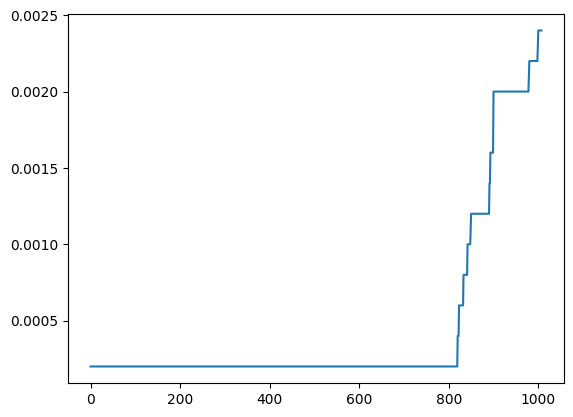

In [38]:
#  First implementation of temporal spreading
# From the plot I am not sure if this is correct, the number of infected nodes is pretty low,
# but that could be because the huge majority of interactions happen at time 1, and i am considering a node as spreader from the next day is infected
# if we remove this condition I expect the number of infected nodes to be almost the same as the number of nodes in the subgraph at day 1

subgraph_reply_df = subgraph_reply_df.sort_values(by=['day'])
subgraph_reply_df.reset_index(drop=True, inplace=True)

iterations = 1
infected_nodes_time_dict = {0:[1 for _ in range(iterations)]}
seed_nodes = []

min_day = min(subgraph_reply_df['day'])
max_day = max(subgraph_reply_df['day'])
number_of_nodes = len(subgraph_reply.nodes())
for n in range(iterations):
    seed_node = random.choice(list(subgraph_reply.nodes()))
    seed_nodes.append(seed_node)
    infected_nodes = {seed_node}

    cur_timestamp = min_day
    nodes_infected_in_timestamp = set()

    # Iterate over all days
    for day in subgraph_reply_df['day']:
        print(f'Iteration {n+1}/{iterations} : {day}/{max_day} --- ', end='\r')
        # For each day get the edges that were created on that day
        edges = subgraph_reply_df[subgraph_reply_df['day'] == day]
        # Take the dataframe subset where either the source or the target is in the infected nodes
        susceptible_nodes_rows = edges[edges['source'].isin(infected_nodes) | edges['target'].isin(infected_nodes)]
        # Make a set of all the nodes that are in susceptible_nodes_rows
        susceptible_nodes = set(susceptible_nodes_rows['source']).union(set(susceptible_nodes_rows['target']))
        # Add the susceptible nodes to the infected nodes
        infected_nodes = infected_nodes.union(susceptible_nodes)
        # Add the infected nodes to the infected_nodes_time_dict
        if day in infected_nodes_time_dict:
            infected_nodes_time_dict[day].append(len(infected_nodes))
        else:
            infected_nodes_time_dict[day] = [len(infected_nodes)]

    # Take the average of the infected nodes for each timestamp
    infected_nodes_time_dict = {k: [np.sum(v)/(len(v)*number_of_nodes)] for k, v in infected_nodes_time_dict.items()}
    plt.clf()
    plt.plot(list(infected_nodes_time_dict.keys()), list(infected_nodes_time_dict.values()))

### Try to find correlations between different networks

In [39]:
G_mention = nx.read_edgelist(friends_mention_path, data=(("day", int),))
G_retweet = nx.read_edgelist(friends_retweet_path, data=(("day", int),))
common_nodes = set(G_reply.nodes()).intersection(set(G_mention.nodes())).intersection(set(G_retweet.nodes()))

seed = random.choice(list(common_nodes))
subgraph_mention = get_subgraph(G_mention, 5000, seed=seed)
subgraph_reply = get_subgraph(G_reply, 5000, seed=seed)
subgraph_retweet = get_subgraph(G_retweet, 5000, seed=seed)
print(subgraph_reply)

subgraph of: 5000 nodes
subgraph of: 5000 nodes
subgraph of: 5000 nodes
Graph with 2 nodes and 1 edges


In [40]:
# Leave only the rows where the source and the target are unique pairs
# subgraph_reply_unique_df = subgraph_reply_df.drop_duplicates(subset=['source', 'target'])
# degrees = subgraph_reply_unique_df.groupby('source').count()
reply_degrees = G_reply.degree()
retweet_degrees = G_retweet.degree()
mention_degrees = G_mention.degree()

# Create a numpy array from reply_degrees where the index is the node id and the value is the degree
i = 0
node_index_dict = {}
for k, v in reply_degrees:
    node_index_dict[k] = i
    i += 1
for k,v in retweet_degrees:
    if k not in node_index_dict.keys():
        node_index_dict[k] = i
        i += 1
for k,v in mention_degrees:
    if k not in node_index_dict.keys():
        node_index_dict[k] = i
        i += 1

total_length = len(reply_degrees) + len(retweet_degrees) + len(mention_degrees)
reply_degrees_array = np.zeros(total_length)
for k, v in reply_degrees:
    reply_degrees_array[node_index_dict[k]] = v
retweet_degrees_array = np.zeros(total_length)
for k, v in retweet_degrees:
    retweet_degrees_array[node_index_dict[k]] = v
mention_degrees_array = np.zeros(total_length)
for k, v in mention_degrees:
    mention_degrees_array[node_index_dict[k]] = v

# Remove trailing zeros from the arrays
# reply_degrees_array = reply_degrees_array[~np.all(reply_degrees_array == 0)]
# retweet_degrees_array = retweet_degrees_array[~np.all(retweet_degrees_array == 0)]
# mention_degrees_array = mention_degrees_array[~np.all(mention_degrees_array == 0)]

# Calculate the correlation between the degrees of the different networks
print(f"Correlation between reply and retweet degrees: {np.corrcoef(reply_degrees_array, retweet_degrees_array)[0,1]}")
print(f"Correlation between reply and mention degrees: {np.corrcoef(reply_degrees_array, mention_degrees_array)[0,1]}")
print(f"Correlation between retweet and mention degrees: {np.corrcoef(retweet_degrees_array, mention_degrees_array)[0,1]}")

Correlation between reply and retweet degrees: 0.8575292740597812
Correlation between reply and mention degrees: 0.8994637310692964
Correlation between retweet and mention degrees: 0.9190546794111863


### Calculate autocorrelation of the number of infected nodes when starting from the node with maximum average degree

In [41]:
# Get only the nodes that have non-zero degree in all the networks
common_nodes = set(G_reply.nodes()).intersection(set(G_mention.nodes())).intersection(set(G_retweet.nodes()))
# Construct a subgraph of each of the reply/mention/retweet graphs with only the common nodes but edges between nodes that are not in the common nodes
print(G_reply.number_of_nodes())
print(G_mention.number_of_nodes())
print(G_retweet.number_of_nodes())
print(len(common_nodes))
G_common_reply = G_reply.subgraph(common_nodes)
G_common_mention = G_mention.subgraph(common_nodes)
G_common_retweet = G_retweet.subgraph(common_nodes)
print(G_common_reply.number_of_nodes())
print(G_common_mention.number_of_nodes())
print(G_common_retweet.number_of_nodes())
# Create degrees_array with the degrees of the nodes in the common nodes subgraph
degrees_array = np.zeros(total_length)
for node in G_common_reply.nodes():
    degrees_array[node_index_dict[node]] = G_common_reply.degree(node) + G_common_mention.degree(node) + G_common_retweet.degree(node)
    print(degrees_array[node_index_dict[node]])
# Get the index of the node with the maximum average degree
print("Degrees", degrees_array)
# Get index of the maximum degree
max_degree_index = np.argmax(degrees_array)
# Get the node with the maximum average degree
max_degree_node = list(node_index_dict.keys())[list(node_index_dict.values()).index(max_degree_index)]
# Get the subgraph of the node with the maximum average degree
subgraph_reply = get_subgraph(G_reply, 5000, seed=max_degree_node)
subgraph_mention = get_subgraph(G_mention, 5000, seed=max_degree_node)
subgraph_retweet = get_subgraph(G_retweet, 5000, seed=max_degree_node)

16937
18222
17094
14375
14375
14375
14375
8.0
20.0
20.0
9.0
941.0
23.0
16.0
5.0
3.0
7.0
12.0
49.0
11.0
6.0
5.0
27.0
11.0
3.0
4.0
1969.0
4.0
3.0
3.0
9.0
39.0
5.0
2.0
4.0
20.0
9.0
3.0
8.0
3.0
3.0
6.0
4.0
3.0
3.0
4.0
3.0
3.0
3.0
3.0
3.0
4.0
8.0
3.0
3.0
6.0
4.0
6.0
5.0
6.0
25.0
5.0
11.0
3.0
18.0
7.0
37.0
164.0
5.0
6.0
23.0
13.0
4.0
9.0
6.0
3.0
4.0
13.0
104.0
10.0
3.0
5.0
6.0
11.0
5.0
11.0
8.0
8.0
5.0
4.0
5.0
8.0
4.0
15.0
5.0
6.0
61.0
6.0
4.0
4.0
14.0
6.0
5.0
5.0
5.0
16.0
3.0
7.0
3.0
3.0
24.0
11.0
11.0
33.0
4.0
5.0
38.0
8.0
4.0
40.0
6.0
5.0
3.0
5.0
8.0
7.0
4.0
32.0
4.0
8.0
4.0
4.0
4.0
3.0
5.0
10.0
55.0
6.0
11.0
3.0
3.0
17.0
4.0
5.0
13.0
12.0
5.0
8.0
3.0
3.0
4.0
36.0
4.0
4.0
4.0
6.0
14.0
5.0
3.0
4.0
3.0
6.0
21.0
5.0
6.0
12.0
7.0
15.0
4.0
3.0
9.0
7.0
5.0
2.0
3.0
7.0
3.0
4.0
4.0
7.0
14.0
5.0
3.0
5.0
8.0
3.0
4.0
6.0
3.0
2.0
7.0
4.0
2.0
3.0
30.0
4.0
5.0
6.0
7.0
3.0
5.0
3.0
6.0
5.0
3.0
3.0
3.0
6.0
5.0
8.0
3.0
3.0
5.0
9.0
15.0
5.0
7.0
6.0
3.0
6.0
11.0
6.0
6.0
5.0
3.0
3.0
4.0
3.0
8.0
11.0
8.0
9.0
3

In [42]:
# Functions for simulating spreading
def simulate_spreading(graph_df, seed_node, start_day, end_day, name = "name_not_given"):

    infected_nodes_time = []
    infected_nodes = {seed_node}

    min_day = start_day
    max_day = end_day
    number_of_nodes = len(subgraph_reply.nodes())

    # Iterate over all days
    for day in np.arange(min_day, max_day+1):
        print(f'Day {day}/{max_day} --- ', end='\r')
        # For each day get the edges that were created on that day
        edges = graph_df[graph_df['day'] == day]
        # Take the dataframe subset where either the source or the target is in the infected nodes
        susceptible_nodes_rows = edges[edges['source'].isin(infected_nodes) | edges['target'].isin(infected_nodes)]
        # Make a set of all the nodes that are in susceptible_nodes_rows
        susceptible_nodes = set(susceptible_nodes_rows['source']).union(set(susceptible_nodes_rows['target']))
        # Add the susceptible nodes to the infected nodes
        infected_nodes = infected_nodes.union(susceptible_nodes)
        # Add the infected nodes to the infected_nodes_time_dict
        infected_nodes_time.append(infected_nodes.copy())

    # Take the number of infected nodes per timestamp
    infected_nodes_ratio_time_count = [len(infected_nodes)/number_of_nodes for infected_nodes in infected_nodes_time]
    # Add legend to the plot

    plt.plot(np.arange(min_day, max_day+1), infected_nodes_ratio_time_count, label=f'{name}')
    plt.legend()
    return infected_nodes_ratio_time_count

def build_df_from_graph(graph):
    graph_df = pd.DataFrame(graph.edges(data=True), columns=['source', 'target', 'attribute'])
    # Extract the 'day' attribute from the 'attribute' column and add it as a separate column
    graph_df['timestamp'] = [d['day'] for d in graph_df['attribute']]
    min_t = min(graph_df['timestamp'])

    # Hardcoded normalizing to ~1000 timesteps
    graph_df['day'] = ((graph_df['timestamp'] - min_t)/ 600).astype(int)
    # subgraph_df['day'] = ((subgraph_df['timestamp'] - min_t)).astype(int)

    # Drop the 'attribute' column, which is no longer needed
    graph_df.drop('attribute', axis=1, inplace=True)

    graph_df.sort_values('day')

    # Simulate temporal spreading starting from the node with the highest average degree
    graph_df = graph_df.sort_values(by=['day'])
    graph_df.reset_index(drop=True, inplace=True)
    return graph_df

Graph with 5000 nodes and 4999 edges
ay 1/1007 --- Day 57/1007 --- Day 358/1007 --- Day 428/1007 --- Day 638/1007 --- Day 852/1007 --- Day 122/1007 --- Day 514/1007 --- Day 727/1007 --- Day 895/1007 --- 

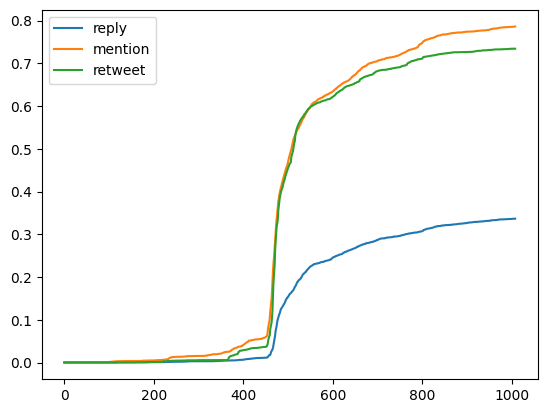

In [43]:
# Simulate spreading for the node with the maximum average degree
print(subgraph_reply)
# Build dataframes for each graph
subgraph_reply_df = build_df_from_graph(subgraph_reply)
subgraph_mention_df = build_df_from_graph(subgraph_mention)
subgraph_retweet_df = build_df_from_graph(subgraph_retweet)

start_day_reply = min(subgraph_reply_df['day'])
start_day_mention = min(subgraph_mention_df['day'])
start_day_retweet = min(subgraph_retweet_df['day'])
end_day_reply = max(subgraph_reply_df['day'])
end_day_mention = max(subgraph_mention_df['day'])
end_day_retweet = max(subgraph_retweet_df['day'])

start_day = min(start_day_reply, start_day_mention, start_day_retweet)
end_day = max(end_day_reply, end_day_mention, end_day_retweet)
reply_infection_rates = simulate_spreading(subgraph_reply_df, max_degree_node, start_day, end_day, name="reply")
mention_infection_rates = simulate_spreading(subgraph_mention_df, max_degree_node, start_day, end_day, name="mention")
retweet_infection_rates = simulate_spreading(subgraph_retweet_df, max_degree_node, start_day, end_day, name="retweet")


[1.5728e-04 3.1456e-04 4.7184e-04 ... 2.0188e-04 1.3460e-04 6.7320e-05]


Text(0.5, 1.0, 'Correlation between infection rates')

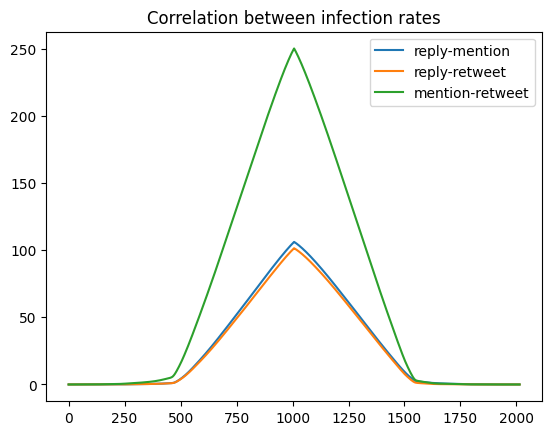

In [44]:
correlation_reply_mention = np.correlate(reply_infection_rates, mention_infection_rates, "full")
correlation_reply_retweet = np.correlate(reply_infection_rates, retweet_infection_rates, "full")
correlation_mention_retweet = np.correlate(mention_infection_rates, retweet_infection_rates, "full")
print(correlation_reply_mention)
plt.clf()
plt.plot(correlation_reply_mention, label="reply-mention")
plt.plot(correlation_reply_retweet, label="reply-retweet")
plt.plot(correlation_mention_retweet, label="mention-retweet")
plt.legend()
plt.title("Correlation between infection rates")